# Simulation and Analysis of the 3-Qubit Repetition Code for Bit-Flip Error Correction 
### 76636-01 – Quantum Computation and Error Correction

This project implements and analyzes the **3-qubit repetition code**, a simple
quantum error-correcting code that protects a single logical qubit against
bit-flip errors. The workflow is implemented step-by-step in Qiskit.

## **Project Steps**
- *Step 1: Encoding*
- *Step 2: Bit-Flip Noise Model*
- *Step 3: Syndrome Extraction*
- *Step 4: Error Correction*
- *Step 5: Decoding*
- *Step 6: Logical Error Rate Analysis*

## Step 1: Encoding Circuit for the 3-Qubit Repetition Code
Create the encoding circuit for the 3-qubit repetition code.
The goal is to take one data qubit in some state |ψ> and distribute it across three physical qubits.
This produces a logical qubit that can tolerate a single bit-flip error.

### How encoding works:

1. Initial State

We start with three qubits:
- q0 = data qubit containing |ψ>
- q1 = |0>
- q2 = |0>
This gives the initial 3-qubit state: |ψ> ⊗ |0> ⊗ |0>

2. Apply Encoding Gates

To encode the logical qubit, we use two CNOT gates:

- CNOT(q0 → q1)
- CNOT(q0 → q2)

These gates copy the value of q0 into q1 and q2.

3. Encoding Results

- Input |0> becomes |000>
- Input |1> becomes |111>
- Input superposition a|0> + b|1> becomes a|000> + b|111>

The function make_repetition_encoding_circuit() builds exactly this encoding block.


In [60]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def make_repetition_encoding_circuit(prepare_one: bool = False):
    # 3 physical qubits: q0 (data), q1 and q2 (ancillas)
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")  # for later for measurements
    qc = QuantumCircuit(qr, cr)

    # prepare |1> on the data qubit before encoding
    if prepare_one:
        qc.x(qr[0])

    # encoding
    qc.cx(qr[0], qr[1])  # CNOT: control q0, target q1
    qc.cx(qr[0], qr[2])  # CNOT: control q0, target q2

    return qc


In [61]:
import numpy as np
from qiskit.quantum_info import Statevector

#--------------------------------------------------
# Helper Function
# Print a Qiskit statevector in a human-readable (formatted) form.
#--------------------------------------------------
def pretty_print_statevector(statevector):
 
    # Convert Statevector → numpy array (safe for all versions)
    if isinstance(statevector, Statevector):
        vec = statevector.data
    else:
        vec = np.asarray(statevector)

    n = int(np.log2(len(vec)))   # number of qubits

    print("Statevector (formatted):")

    printed_any = False

    for index, amplitude in enumerate(vec):
        if abs(amplitude) > 1e-10:  # ignore tiny values
            binary = format(index, f'0{n}b')
            amp_str = f"{amplitude.real:.4f}"
            if amplitude.imag >= 0:
                amp_str += f"+{amplitude.imag:.4f}i"
            else:
                amp_str += f"{amplitude.imag:.4f}i"

            print(f"  {amp_str} |{binary}>")
            printed_any = True

    if not printed_any:
        print("  (all amplitudes are zero?)")



### Testing the Encoding Circuit

In this section, we verify that the encoding circuit works correctly.

We perform three tests:

#### **Test 1 — Encode logical |0>**
- Input: |0>
- Expected output after encoding: |000>
#### **Test 2 — Encode logical |1>**
- Input: |1>
- Expected output after encoding: |111>
#### **Test 3 — Encode superposition |+>**
- Input: |+> = (|0> + |1>) / sqrt(2)
- Expected output after encoding: (1/sqrt(2)) |000> + (1/sqrt(2)) |111>

In [62]:
from qiskit_aer import Aer

sim = Aer.get_backend("statevector_simulator")

print("=== Test 1: Input |0> ===")
qc0 = make_repetition_encoding_circuit(prepare_one=False)
job0 = sim.run(qc0)
state0 = job0.result().get_statevector()
pretty_print_statevector(state0)
#print(state0)

print("\n=== Test 2: Input |1> ===")
qc1 = make_repetition_encoding_circuit(prepare_one=True)
job1 = sim.run(qc1)
state1 = job1.result().get_statevector()
pretty_print_statevector(state1)
#print(state1)

print("\n=== Test 3: Input |+> superposition ===")
# Prepare |+> on q0 before encoding
qc_plus = make_repetition_encoding_circuit()
qc_plus.h(0)   # put q0 into superposition BEFORE encoding
qc_plus.cx(0, 1)      # encode
qc_plus.cx(0, 2)

state_plus = sim.run(qc_plus).result().get_statevector()
pretty_print_statevector(state_plus)


=== Test 1: Input |0> ===
Statevector (formatted):
  1.0000+0.0000i |000>

=== Test 2: Input |1> ===
Statevector (formatted):
  1.0000+0.0000i |111>

=== Test 3: Input |+> superposition ===
Statevector (formatted):
  0.7071+0.0000i |000>
  0.7071+0.0000i |111>


## Step 2: Bit-Flip Noise Model

Simulate *bit-flip noise* acting independently on each of the
three encoded qubits.

Bit-flip noise means:
- with probability **p**, a qubit is flipped (X gate applied)
- with probability **1 – p**, the qubit is left unchanged

This models real noise sources such as gate imperfections and environmental
interference.

We will use the Qiskit Aer noise module to:
1. Define a bit-flip error channel
2. Add it to a noise model
3. Apply this noise to the encoded qubits
4. Run a simple test to observe the effect of noise

In [63]:
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer import Aer

# Create a noise model that applies an X (bit flip) error
# with probability p to each qubit.
def make_bitflip_noise_model(p):

    # Define a single-qubit bit-flip error
    bitflip = pauli_error([('X', p), ('I', 1 - p)])

    # Make a noise model and attach this error to all qubits
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(bitflip, ['id', 'x'])

    return noise_model

### Testing the Bit-Flip Noise Model

We test the bit-flip noise model using a physical error
probability **p = 0.2**. Each encoded qubit undergoes a bit-flip (X error) with
probability `p`, and remains unchanged with probability `1 - p`. Because we use
the density-matrix simulator, the results appear as density matrices whose
diagonal entries represent the probabilities of each basis state.

**Encoded |000> under noise (p = 0.2)**  
The diagonal probabilities we obtained were approximately:
- 0.512 on `|000>` → no flips  
- 0.128 on each of `|001>`, `|010>`, `|100>` → exactly one flip  
- 0.032 on each of `|011>`, `|101>`, `|110>` → two flips  
- 0.008 on `|111>` → three flips  

These values match the theoretical probabilities:
- `(1 - p)^3 = 0.512`  
- `3 * p * (1 - p)^2 = 0.384`  
- `3 * p^2 * (1 - p) = 0.096`  
- `p^3 = 0.008`

**Encoded |111> under noise (p = 0.2)**  
The second density matrix shows the same pattern of probabilities, but mirrored
to the basis states around `|111>` (since flipping bits of `|111>` moves
probability toward states like `|110>`, `|101>`, … , `|000>`).

These results confirm that our noise model is applied correctly and behaves
exactly according to the bit-flip error distribution.


In [64]:
#-------------------------------------
#  Helper Function
#-------------------------------------
import numpy as np
from qiskit.quantum_info import DensityMatrix

def print_probabilities_from_density_matrix(rho):
    # Given a Qiskit density matrix (8x8 for 3 qubits),
    # print the probabilities for each computational basis state.

    # Convert to numpy array if needed
    if isinstance(rho, DensityMatrix):
        matrix = rho.data
    else:
        matrix = np.asarray(rho)

    # Number of qubits
    dim = matrix.shape[0]
    n = int(np.log2(dim))

    print("Probabilities for each basis state:")
    for idx in range(dim):
        prob = matrix[idx, idx].real  # diagonal element (probability)
        if prob > 1e-12:
            binary = format(idx, f'0{n}b')  # e.g., "000", "011", ...
            print(f"  |{binary}> : {prob:.4f}")


In [65]:
#--- Test Noise Model

from qiskit_aer import AerSimulator

# Choose noise level
p = 0.2
noise_model = make_bitflip_noise_model(p)

sim = AerSimulator(method="density_matrix")

print("=== Test A: Bit-flip noise on encoded |000> ===")
qc0 = make_repetition_encoding_circuit(prepare_one=False)
qc0.id(0); qc0.id(1); qc0.id(2)
qc0.save_density_matrix()
result0 = sim.run(qc0, noise_model=noise_model).result()
rho0 = result0.data(0)["density_matrix"]
print(rho0)
print("=== Probabilities for noisy encoded |000> ===")
print_probabilities_from_density_matrix(rho0)

print("\n=== Test B: Bit-flip noise on encoded |111> ===")
qc1 = make_repetition_encoding_circuit(prepare_one=True)
qc1.id(0); qc1.id(1); qc1.id(2)
qc1.save_density_matrix()
result1 = sim.run(qc1, noise_model=noise_model).result()
rho1 = result1.data(0)["density_matrix"]
print(rho1)
print("\n=== Probabilities for noisy encoded |111> ===")
print_probabilities_from_density_matrix(rho1)


=== Test A: Bit-flip noise on encoded |000> ===
DensityMatrix([[0.512+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.128+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.128+0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.032+0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.128+0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.032+0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.032+0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0

## Step 3: Syndrome Extraction

Now we add **syndrome qubits** to detect which of the three encoded
qubits has flipped.

We introduce two ancilla (syndrome) qubits:
- `s1` detects whether `q0` and `q1` are different,
- `s2` detects whether `q1` and `q2` are different.

We compute:
- `s1 = q0 XOR q1`
- `s2 = q1 XOR q2`

This is implemented with CNOT gates:
- for `s1`: CNOT(q0 → s1), CNOT(q1 → s1)
- for `s2`: CNOT(q1 → s2), CNOT(q2 → s2)

We then measure `s1` and `s2` into two classical bits. The possible syndromes
tell us where the error occurred:

- `00` → no error
- `10` → bit-flip on q0
- `11` → bit-flip on q1
- `01` → bit-flip on q2

In this step, we build a circuit that:
1. encodes the logical 0 state into `|000>`,
2. optionally applies a bit-flip (X) to one of the three qubits,
3. extracts the syndrome using the two ancilla qubits,
4. measures the syndrome bits.

In [66]:
from qiskit import QuantumCircuit

#=================================================
# Build a 5-qubit circuit for the 3-qubit repetition code with syndrome extraction.
# Qubits:
#  q0, q1, q2 : data qubits (encoded repetition code)
#  q3         : syndrome qubit s1 = q0 XOR q1
#  q4         : syndrome qubit s2 = q1 XOR q2
# If error_qubit is 0, 1, or 2, an X error is applied to that data qubit.
# If error_qubit is None, no error is applied.
#=================================================
def make_syndrome_extraction_circuit(error_qubit=None):
    
    qc = QuantumCircuit(5, 2)  # 5 qubits, 2 classical bits for the syndrome

    # Encode logical 0: |0> -> |000>
    # Initial state is |00000>, so data qubits start as |000>.
    # Encoding: q0 controls q1 and q2.
    qc.cx(0, 1)
    qc.cx(0, 2)

    # Optional bit-flip error on one of the data qubits
    if error_qubit is not None:
        qc.x(error_qubit)

    # Syndrome extraction
    # s1 = q0 XOR q1 stored in qubit 3
    qc.cx(0, 3)
    qc.cx(1, 3)
    # s2 = q1 XOR q2 stored in qubit 4
    qc.cx(1, 4)
    qc.cx(2, 4)

    # Measure the syndrome qubits ---
    # Map:
    # c0 <- s1 (q3)
    # c1 <- s2 (q4)
    qc.measure(3, 0)
    qc.measure(4, 1)

    return qc


### Testing the Syndrome Extraction Circuit

Test whether the syndrome extraction works correctly.  
After encoding the logical state `|000>`, we optionally apply a bit-flip error  
to one of the data qubits and measure the two syndrome qubits.

The expected syndromes are:

- **00** → no error  
- **01** → error on q0  
- **11** → error on q1  
- **10** → error on q2  

The bitstrings printed by Qiskit follow the order **c1 c0**,  
so the left bit corresponds to the `q1 ⊕ q2` check (s2),  
and the right bit corresponds to the `q0 ⊕ q1` check (s1).

These tests confirm that the circuit correctly detects  
which qubit has flipped.

In [67]:
from qiskit_aer import AerSimulator

sim = AerSimulator()

def run_syndrome_test(label, error_qubit):
    qc = make_syndrome_extraction_circuit(error_qubit=error_qubit)
    result = sim.run(qc, shots=1024).result()
    counts = result.get_counts()
    print(f"{label} (error_qubit = {error_qubit})")
    print("  counts:", counts)
    print()

print("=== Syndrome tests ===")
run_syndrome_test("No error", None)
run_syndrome_test("Error on q0", 0)
run_syndrome_test("Error on q1", 1)
run_syndrome_test("Error on q2", 2)


=== Syndrome tests ===
No error (error_qubit = None)
  counts: {'00': 1024}

Error on q0 (error_qubit = 0)
  counts: {'01': 1024}

Error on q1 (error_qubit = 1)
  counts: {'11': 1024}

Error on q2 (error_qubit = 2)
  counts: {'10': 1024}



## Step 4: Error Correction

Once the syndrome has been measured, we know which of the three data qubits
(q0, q1, q2) experienced a bit-flip error.  
In this step, we apply the appropriate correction.

Based on the syndrome:

- **00** → no error  
- **01** → flip on q0 → apply X to q0  
- **11** → flip on q1 → apply X to q1  
- **10** → flip on q2 → apply X to q2  

To implement this, we:
1. encode the logical state `|000>`,  
2. (optionally) introduce a bit-flip error,  
3. extract the syndrome using the two ancilla qubits,  
4. read the measured syndrome bits,  
5. apply the corresponding corrective X gate on the affected qubit.

This step verifies that after correction, the three data qubits return to the
correct codeword (`|000>`).


In [68]:
#=================================================
#   Build a 5-qubit circuit that:
#   1. encodes |000> using repetition encoding
#   2. optionally applies an X error to one of q0, q1, q2
#   3. extracts the syndrome using q3 and q4
#   4. applies the correction based on the syndrome (classical logic)
#   5. measures the data qubits at the end
#=================================================
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

def make_full_correction_circuit(error_qubit=None):

    qr = QuantumRegister(5, "q")     # data + syndrome qubits
    cr = ClassicalRegister(5, "c")   # classical bits
    qc = QuantumCircuit(qr, cr)

    # Encode logical 0 -> |000>
    qc.cx(qr[0], qr[1])
    qc.cx(qr[0], qr[2])

    # Optional X error
    if error_qubit is not None:
        qc.x(qr[error_qubit])

    # Syndrome extraction
    qc.cx(qr[0], qr[3])
    qc.cx(qr[1], qr[3])

    qc.cx(qr[1], qr[4])
    qc.cx(qr[2], qr[4])

    qc.measure(qr[3], cr[0])  # s1
    qc.measure(qr[4], cr[1])  # s2

    # Correction
    with qc.if_test((cr, 0b00001)):   # syndrome = 01 -> flip q0
        qc.x(qr[0])

    with qc.if_test((cr, 0b00011)):   # syndrome = 11 -> flip q1
        qc.x(qr[1])

    with qc.if_test((cr, 0b00010)):   # syndrome = 10 -> flip q2
        qc.x(qr[2])

    # Final measurement of data qubits
    qc.measure(qr[0], cr[2])
    qc.measure(qr[1], cr[3])
    qc.measure(qr[2], cr[4])

    return qc


### Testing the Error Correction Circuit

Verify that the full error-correction procedure works correctly. 
For each test:

1. Encode the logical state `|0>` as `|000>`,
2. Optionally introduce a bit-flip error on one of the data qubits,
3. Extract the syndrome using two ancilla qubits,
4. Apply the appropriate correction based on the measured syndrome,
5. Measure the final data qubits.

The classical readout contains 5 bits:  
- `c1 c0` = syndrome bits  
- `c4 c3 c2` = final data qubits  

The test results were:

- **No error:** `00000`  
- **Error on q0:** `00001`  
- **Error on q1:** `00011`  
- **Error on q2:** `00010`  

In all cases, the three data qubits are `000`, which
confirms that the error was correctly identified and corrected.


In [69]:
from qiskit_aer import AerSimulator

sim = AerSimulator()

def run_correction_test(label, error_qubit):
    qc = make_full_correction_circuit(error_qubit=error_qubit)
    result = sim.run(qc, shots=1024).result()
    counts = result.get_counts()
    print(f"{label} (error_qubit = {error_qubit})")
    print("  final data qubit counts:", counts)
    print()

print("=== Error Correction Tests ===")
run_correction_test("No error", None)
run_correction_test("Error on q0", 0)
run_correction_test("Error on q1", 1)
run_correction_test("Error on q2", 2)


=== Error Correction Tests ===
No error (error_qubit = None)
  final data qubit counts: {'00000': 1024}

Error on q0 (error_qubit = 0)
  final data qubit counts: {'00001': 1024}

Error on q1 (error_qubit = 1)
  final data qubit counts: {'00011': 1024}

Error on q2 (error_qubit = 2)
  final data qubit counts: {'00010': 1024}



## Step 5: Decoding

After correcting errors and restoring the three data qubits to the codeword
`|000>` or `|111>`, we finish by decoding the logical qubit. Decoding simply
reverses the encoding operation.

For the 3-qubit repetition code:

- Encoding used two CNOTs:  
  `CNOT(q0 → q1)` and `CNOT(q0 → q2)`

- Decoding applies the same CNOTs in reverse order:  
  `CNOT(q0 → q2)` and then `CNOT(q0 → q1)`

This returns the logical qubit back to a single physical qubit (q0), and we
measure q0 to determine the decoded logical value.

For this project, we decode only the corrected codeword, expecting the output
to be:

- `|0>` when no logical error occurred
- `|1>` if a logical error occurred (e.g., 2 or more flips)


In [70]:
#===================================================
# Create a decoding block.
# This block reverses the 3-qubit repetition encoding.
#===================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def make_decoding_circuit():

    qr = QuantumRegister(3, "q")
    qc = QuantumCircuit(qr)

    # Decoding = reverse encoding
    qc.cx(qr[0], qr[2])   # undo second encoding CNOT
    qc.cx(qr[0], qr[1])   # undo first encoding CNOT

    return qc

### Testing the Decoding Circuit

Verify that the decoding block correctly reverses the encoding
operation of the 3-qubit repetition code. The decoding consists of two CNOT
gates that undo the original encoding and recover the logical qubit on `q0`.

We test two cases:

- **Input `|000>`** — the encoded logical `|0>`  
  After decoding, we expect to measure `0`.

- **Input `|111>`** — the encoded logical `|1>`  
  After decoding, we expect to measure `1`.

Running each circuit for 1024 shots produced:

- `|000>` → **{'0': 1024}**  
- `|111>` → **{'1': 1024}**

These results confirm that the decoding block functions correctly and restores
the logical qubit value without error.


In [71]:

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sim = AerSimulator()

#==========================================
# Initial_state must be '000' or '111'.
# The test prepares a 3-qubit encoded state,
# composes the decoding circuit,
# and measures the decoded logical qubit.
#==========================================
def run_decoding_test(state_label, initial_state):

    # Create 3-qubit circuit + 1 classical bit for measurement
    qc = QuantumCircuit(3, 1)

    # Prepare encoded input
    if initial_state == "111":
        qc.x(0)
        qc.x(1)
        qc.x(2)

    # Append decoding
    decoding_block = make_decoding_circuit()
    qc = qc.compose(decoding_block, qubits=[0,1,2])

    # Measure decoded logical qubit
    qc.measure(0, 0)

    # Run
    result = sim.run(qc, shots=1024).result()
    counts = result.get_counts()
    print(f"{state_label} (input={initial_state}) → decoded:", counts)


print("=== Decoding Tests ===")
run_decoding_test("Decode |000>", "000")   # expected: {'0': 1024}
run_decoding_test("Decode |111>", "111")   # expected: {'1': 1024}


=== Decoding Tests ===
Decode |000> (input=000) → decoded: {'0': 1024}
Decode |111> (input=111) → decoded: {'1': 1024}


## Step 6: Logical Error Rate Analysis

In this final step, we evaluate how well the 3-qubit repetition code suppresses
errors. For a range of physical error probabilities `p`, we repeatedly run the
full process:

1. Encode logical `|0>` → `|000>`
2. Apply independent bit-flip noise with probability `p`
3. Extract the syndrome
4. Apply the correction
5. Decode the logical qubit
6. Measure the final value

For each value of `p`, we estimate the **logical error rate**:

$$
p_L = P(\text{decoded output is }1 \mid \text{input logical }0).
$$

A successful error-correcting code should satisfy:

$$
p_L < p \quad \text{for small } p.
$$

We will simulate this behavior and plot the resulting logical error rate versus
the physical error probability.


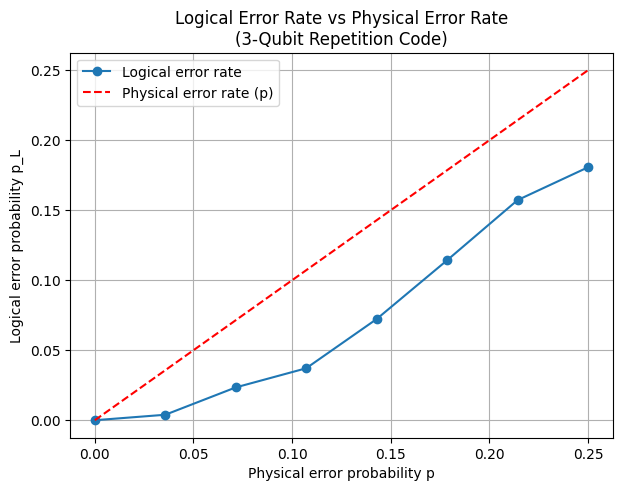

In [72]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
import matplotlib.pyplot as plt

# Noise Helper
def make_bitflip_noise_model(p):
    bitflip = pauli_error([('X', p), ('I', 1 - p)])
    model = NoiseModel()
    model.add_all_qubit_quantum_error(bitflip, ['id', 'x'])
    return model


#================================================================
# Build Full Circuit that does the whole pipeline for a logical 0
# Full cycle:
# encode |000>, noise, syndrome, correction, decode, measure logical qubit.
#================================================================
def build_full_cycle_circuit(p):

    # 5 quantum bits: 3 data + 2 syndrome
    # 1 classical bit for decoded logical value
    qr = QuantumRegister(5, "q")
    cr = ClassicalRegister(5, "c")
    qc = QuantumCircuit(qr, cr)

    # Encode |0> -> |000>
    qc.cx(qr[0], qr[1])
    qc.cx(qr[0], qr[2])

    # Insert idle IDs - where noise can occur
    qc.id(qr[0]); qc.id(qr[1]); qc.id(qr[2])

    # Syndrome extraction
    qc.cx(qr[0], qr[3])
    qc.cx(qr[1], qr[3])
    qc.cx(qr[1], qr[4])
    qc.cx(qr[2], qr[4])

    # Measure syndrome bits
    qc.measure(qr[3], cr[0])
    qc.measure(qr[4], cr[1])

    # Correction
    with qc.if_test((cr, 0b00001)):  # syndrome 01 -> flip q0
        qc.x(qr[0])
    with qc.if_test((cr, 0b00011)):  # syndrome 11 -> flip q1
        qc.x(qr[1])
    with qc.if_test((cr, 0b00010)):  # syndrome 10 -> flip q2
        qc.x(qr[2])

    # Decode: undo encoding
    qc.cx(qr[0], qr[2])
    qc.cx(qr[0], qr[1])

    # Measure decoded logical qubit into c[2]
    qc.measure(qr[0], cr[2])

    return qc


# Main simulation loop
def estimate_logical_error_rate(p, shots=1024):
    noise_model = make_bitflip_noise_model(p)
    sim = AerSimulator(method="automatic")
    qc = build_full_cycle_circuit(p)
    result = sim.run(qc, noise_model=noise_model, shots=shots).result()
    counts = result.get_counts()

    # decoded logical 1 = error
    errors = sum(counts.get(key, 0) for key in counts if key[-3] == "1")
    return errors / shots


# Sweep over physical error rates
p_values = np.linspace(0, 0.25, 8)
logical_error_rates = [estimate_logical_error_rate(p) for p in p_values]

# Plot
plt.figure(figsize=(7,5))
plt.plot(p_values, logical_error_rates, 'o-', label="Logical error rate")
plt.plot(p_values, p_values, 'r--', label="Physical error rate (p)")
plt.xlabel("Physical error probability p")
plt.ylabel("Logical error probability p_L")
plt.title("Logical Error Rate vs Physical Error Rate\n(3-Qubit Repetition Code)")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion

The results show that the 3-qubit repetition code successfully suppresses
bit-flip errors when the physical error probability is small. In this region,
the logical error rate $p_L$ is significantly lower than the physical error
rate $p$, demonstrating effective error correction.

As $p$ increases, multi-qubit errors become more likely, and the code is no
longer able to correct all errors. Consequently, the logical error rate rises
and eventually approaches the physical error rate. This behavior matches the
theoretical limits of the repetition code, which can correct only a single
bit-flip error.

Overall, the experiment confirms that the repetition code improves reliability
only in the low-noise regime, illustrating the core principle of quantum error
correction.
